In [1]:
import pandas as pd
import numpy as np
import codepub as cdp
import math

import tqdm

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sn

# Empirical balance of pooling schemes with DCP-CWGCs.

Comparison of the deviations $\delta_C = \max(W_C) - \min(W_C)$ of BBA-derived and rcBBA-derived experimental balance. Each dot represents one DCP-CWGC with a deviation $\delta_C$. A total of 10 runs are shown per parameter set ($m, r, n$).

In [2]:
cdp.set_seed(123)

bba_balance_mult = dict()
for i in tqdm.tqdm(range(50, 1000, 100)):
    balance_dev = []
    for x in range(10):
        b, lines = cdp.bba(m=16, r=4, n=i)
        balance_dev.append(np.max(b) - np.min(b))
    bba_balance_mult[i] = balance_dev

cdp.set_seed(123)
rca_balance_mult = dict()
for i in tqdm.tqdm(range(50, 1000, 100)):
    balance_dev = []
    for x in range(10):
        b, lines = cdp.rcbba(m=16, r=4, n=i)
        balance_dev.append(np.max(b) - np.min(b))
    rca_balance_mult[i] = balance_dev

100%|███████████████████████████████████████████| 10/10 [01:03<00:00,  6.31s/it]


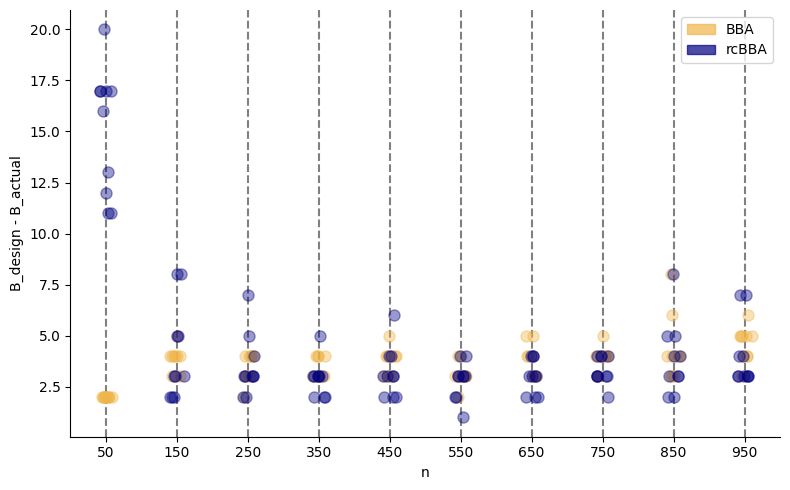

In [3]:
## deviation plot

fig = plt.figure(figsize=(8, 5))

bba_color = '#F0B54A'
rcbba_color = '#000080'

ax = sn.stripplot(bba_balance_mult, label = 'BBA', color = bba_color, jitter=0.1,
             s=8, alpha = 0.4, edgecolor = bba_color, linewidth = 1)
ax = sn.stripplot(rca_balance_mult, label = 'rcBBA', color = rcbba_color, jitter=0.1,
             s=8, alpha = 0.4, edgecolor = rcbba_color, linewidth = 1)

plt.xlabel('n')
plt.ylabel('B_design - B_actual')
patch2 = mpatches.Patch(color = bba_color, alpha = 0.7, label = 'BBA')
patch1 = mpatches.Patch(color = rcbba_color, alpha = 0.7, label ='rcBBA')
plt.legend(handles=[patch2, patch1], loc='upper right')

for x in range(10):
    plt.axvline(x, ls='--', color='gray')

sn.despine(ax=ax)
plt.tight_layout()

# Empirical runtime analyses for BBA and rcBBA.

Runtime is evaluated as a function of code length $n$, with varying address lengths $m$ and address weights $r$. The process was executed on a single core of a general-purpose CPU node equipped with dual Xeon 6252 processors. It utilized 16.5 GB of virtual memory, with 69.4 MB resident in RAM.

## r = 4, not fixed m

In [4]:
bba_results_time_fixR4 = pd.read_csv('./results/bba_running_time_fixR4.tsv',
                                 sep = "\t")
bba_results_time_fixR4 = bba_results_time_fixR4[bba_results_time_fixR4['m'] > 20]
rcbba_results_time_fixR4 = pd.read_csv('./results/rcbba_running_time_fixR4.tsv',
                                     sep = "\t")
rcbba_results_time_fixR4 = rcbba_results_time_fixR4[rcbba_results_time_fixR4['m'] > 20]

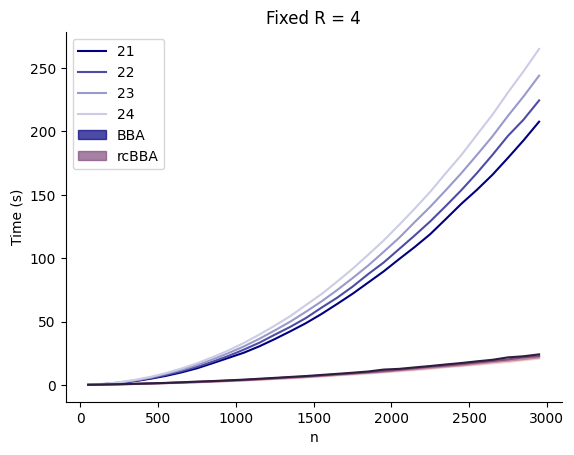

In [5]:
colors = ['#000080', '#4D4DA6', '#9999CC', '#CCCCE6']

plot = sn.lineplot(data = bba_results_time_fixR4, x = 'n', y = 'Time (s)', hue = 'm', palette = colors)
plot = sn.lineplot(data = rcbba_results_time_fixR4, x = 'n', y = 'Time (s)', hue = 'm', legend = False)

patch_bba = mpatches.Patch(color = colors[0], alpha = 0.7, label = 'BBA')
patch_rcbba = mpatches.Patch(color = '#824C7D', alpha = 0.7, label ='rcBBA')

handles, labels = plot.get_legend_handles_labels()
combined_handles = handles + [patch_bba, patch_rcbba]
combined_labels = labels + ['BBA', 'rcBBA']
plot.legend(combined_handles, combined_labels, loc='upper left')
plot.set_title('Fixed R = 4')
sn.despine(ax=plot)

## m = 20, not fixed r

In [6]:
bba_results_time_fixM20 = pd.read_csv('./results/bba_running_time_fixM20.tsv',
                                 sep = "\t")
rcbba_results_time_fixM20 = pd.read_csv('./results/rcbba_running_time_fixM20.tsv',
                                     sep = "\t")

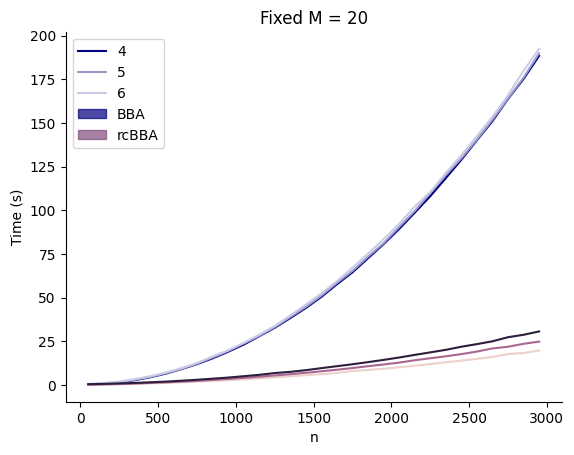

In [7]:
colors = ['#000080', '#9999CC', '#CCCCE6']

plot = sn.lineplot(data = bba_results_time_fixM20, x = 'n', y = 'Time (s)', hue = 'r', palette = colors)
plot = sn.lineplot(data = rcbba_results_time_fixM20, x = 'n', y = 'Time (s)', hue = 'r', legend = False)

patch_bba = mpatches.Patch(color = colors[0], alpha = 0.7, label = 'BBA')
patch_rcbba = mpatches.Patch(color = '#824C7D', alpha = 0.7, label ='rcBBA')

handles, labels = plot.get_legend_handles_labels()
combined_handles = handles + [patch_bba, patch_rcbba]
combined_labels = labels + ['BBA', 'rcBBA']
plot.legend(combined_handles, combined_labels, loc='upper left')

plot.set_title('Fixed M = 20')
sn.despine(ax=plot)

# Performance of BBA and rcBBA near the theoretical bound.

The theoretical bound lies at the combinatorial coefficient for $n$ with  $\text{min}\{\binom{m}{r}, \binom{m}{r+1}+1\}$.  For a fixed number of pools $m$, BBA and rcBBA approach the theoretical bound with increasing address weights $r$.

In [8]:
bba_df = pd.read_csv('./results/bba_lim_failures.tsv', sep = "\t")
rcbba_df = pd.read_csv('./results/rcbba_lim_failures.tsv', sep = "\t")

ms = rcbba_df[['m', 'r']].drop_duplicates()['m']
rs = rcbba_df[['m', 'r']].drop_duplicates()['r']

rcbba_rows = []
bba_rows = []
for m, r in tqdm.tqdm(zip(ms, rs)):
    rcbba_filt = rcbba_df[(rcbba_df['m'] == m) & (rcbba_df['r'] == r) & (rcbba_df['Time (s)'] < 400)]
    rcbba_rows.append({'m': m, 'r': r, 'max_n': np.max(rcbba_filt['real_n'])})
    bba_filt = bba_df[(bba_df['m'] == m) & (bba_df['r'] == r) & (bba_df['Time (s)'] < 400)]
    bba_rows.append({'m': m, 'r': r, 'max_n': np.max(bba_filt['real_n'])})

rcbba_df_m = pd.DataFrame(rcbba_rows, columns=['m', 'r', 'max_n'])
bba_df_m = pd.DataFrame(bba_rows, columns=['m', 'r', 'max_n'])

45it [00:00, 2205.98it/s]


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 246.95it/s]


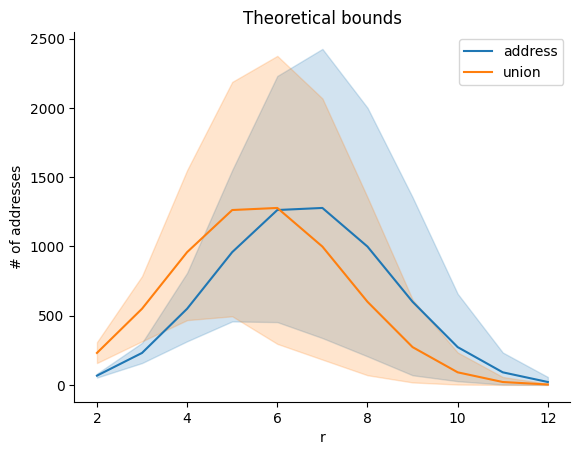

In [9]:
data = pd.DataFrame(columns = ['m', 'Iters', 'r','# of addresses', '# of unions'])

for m in tqdm.tqdm(range(10, 15)):
    for r in range(2, 13):
        row = pd.DataFrame({'m':m, 'r':r, 'Unions':r+1,'# of addresses':math.comb(m, r),
                           '# of unions':math.comb(m, r+1)}, index=[0])
        data = pd.concat([data, row])

sn.lineplot(data = data, y='# of addresses', x='r', label = 'address')
sn.lineplot(data = data, y='# of unions', x='r', label = 'union')
plt.title('Theoretical bounds')
sn.despine()

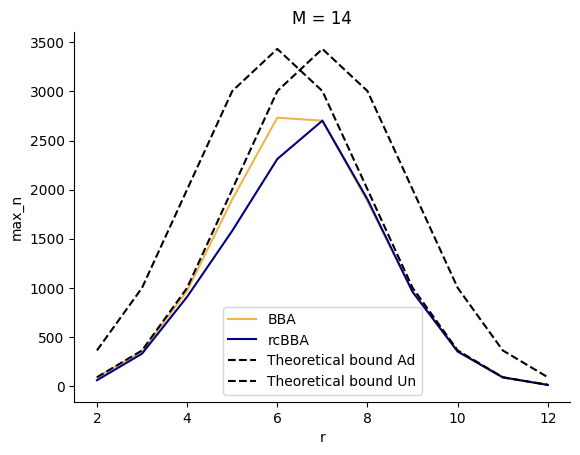

In [10]:
bba_color = '#F0B54A'
rcbba_color = '#000080'

sn.lineplot(bba_df_m[(bba_df_m['m'] == 14)], x = 'r', y = 'max_n', label = 'BBA', color = bba_color)
sn.lineplot(rcbba_df_m[(rcbba_df_m['m'] == 14)], x = 'r', y = 'max_n', label = 'rcBBA', color = rcbba_color)
sn.lineplot(data = data[(data['m'] == 14)], y='# of addresses', x='r',
            label = 'Theoretical bound Ad', color = 'black', linestyle = '--')
sn.lineplot(data = data[(data['m'] == 14)], y='# of unions', x='r',
            label = 'Theoretical bound Un', color = 'black', linestyle = '--')
plt.legend()
plt.title('M = 14')
sn.despine()

# Experimental error detection with DCP-CWGCs-derived pooling schemes

For a fixed number of pools $m = 18$ and address weight $r = 6$, the number of target item candidates depends on the number of tested items $n$ and the number of erroneous non-positive pools. Each set of parameters was tested once; for every item, the results of all possible errors were simulated.

In [11]:
data = pd.read_csv('./results/error_plot_M18_R6_fixed_ends.tsv', sep = "\t")

Displayed:
* items with overlap in sequence = 12;
* 2 neighboring items share only 1 substring of particular lenght;
* not more than 3 errors

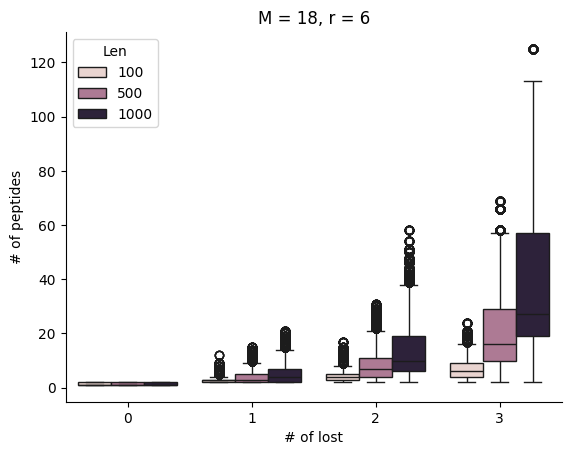

In [12]:
for_display = data[(data['Shift'] == 12) & (data['# of lost'] < 4)]
ax = sn.boxplot(data = for_display, x = '# of lost', y = '# of peptides', hue = 'Len')
ax.set_title('M = 18, r = 6')
sn.despine(ax=ax)

# The length of the DCP-CWGC component $n_j$ generated with each iteration $j$

Due to rcBBA's iterative nature with decreasing $j$, the theoretical bound for the length of the component codes, i.e., $\text{min}\{\binom{j}{r-1}, \binom{j}{r}+1\}$, also decreases with each iteration. To avoid reaching this theoretical bound before construction is completed, rcBBA switches to the final iteration regime at an arbitrary $j = 2r$. Orange dots represent elementary codes with length $n_j$ produced during each rcBBA iterations, the blue dot represents the elementary code with length $n_j$ produced at the last iteration. The solid line is the cumulative length of the arrangement.

## functions from codepub but returning n_j values too

In [13]:
from itertools import combinations
import sys
import random

# These two were altered
def reccom(j, r, n, I_res, weights, used_n_values, w_check = None, H=None):

    """
    Adds component to the arrangement, searches for next component. Recursive, core function in rcbba algorithm.

    Parameters:
    - j (int) - number of pools, iteration counter
    - r (int) - address weight, i.e. to how many pools one item is added
    - n (int) - number of items
    - I_res (list) - residual index set
    - weights (numpy array) - residual balance vector
    - w_check (numpy array) - residual balance vector before adding next component
    - H (numpy array) - arrangement

    Returns:
    - H (numpy array) - arrangement with added next component
    """
    
    if H is None:
        m_0_check = math.comb(j-1, r) < math.comb(j-1, r-1)+1
        if m_0_check:
            _, H_new = bba(j, r, n, W_des = list(weights))
            if H_new is not None:
                H_new = np.array(H_new, dtype = 'int')
                used_n_values[j] = [n, 'bba', len(H_new)]
                return H_new
        else:
            w = weights[-1]
            H, I_res = gen_elementary_sequence(j, r, I_res, w, b = None)
            if H is None:
                return None
            used_n_values[j] = [w, 'rcbba', len(H)]
            w_check = item_per_pool(H, len(weights))
        
    m_pools = len(weights)
    
    # balance in the arrangement
    new_weights = weights - w_check
    bs = bAU_search(H, m_pools, I_res)
    b_weights = dict()
    for b in bs:
        b_weights[tuple(b)] = new_weights[b[-1]]
    b_weights = {k: v for k, v in sorted(b_weights.items(), key=lambda item: item[1], reverse=False)}
            
    # j iteration
    j = j - 1

    # last elementary sequence
    if math.comb(j-1, r) < math.comb(j-1, r-1)+1:
        print(j, r, 'unions', math.comb(j-1, r), 'addresses', math.comb(j-1, r-1)+1)
        left = n - len(H)
        for b in b_weights.keys():
                
            # calculating balance for BBA_AU
            start_a = ''.join(['1']*r + ['0']*(j-r))
            perm_vec = permute(list(range(r)), b, j, I_res)
            W_des = AU_balance(new_weights, perm_vec)
            # search for the arrangement with needed balance
            _, A = bba(j, r, left, start_a, W_des)
            
            if A is not None:
                A = np.array(A, dtype = 'int')
                H_j = permutation_map(A[::-1], -1, b, j, I_res)
                if H_j is not None:
                    H_new = np.concatenate([H_j, H], axis=0)
                    used_n_values[j] = [left, 'bba', len(H_new)]
                        
                    return H_new

    # for each b
    for b in b_weights.keys():
        w = b_weights[b]
        av_ad = math.comb(j-1, r-1)
        av_un = math.comb(j-1, r)
        # if AU arrangement can be found
        if w > 0 and w < av_un and av_ad - w > 1:
            #if w is bigger than needed
            if w > n-len(H):
                w = n-len(H)
            H_j, I_res_new = gen_elementary_sequence(j, r, I_res, w, b)
            if H_j is not None:
                w_check = item_per_pool(H_j, len(weights))
                H_new = np.concatenate([H_j, H], axis=0)
                used_n_values[j] = [w, 'rcbba', len(H_new)]

                if len(H_new) == n:
                    return H_new

                # if arrangement needs only one next element
                elif n-len(H_new) == 1:
                    end = bAU_search(H_new, m_pools, I_res_new)
                    if len(end)>0:
                        b_H = np.concatenate([[end[0]], H_new], axis=0)
                        used_n_values[j] = [1, 'last', len(b_H)]
                        return b_H
            
                else:
                    res_H = reccom(j, r, n, I_res_new, new_weights, used_n_values, w_check, H_new)
                    if res_H is not None:
                        return res_H


def rcbba(m, r, n):

    """
    Searches for the arrangement of length n, with m pools, r address weight using rcBBA algorithm.

    Parameters:
    - m (int) - number of pools
    - r (int) - address weight, i.e. to how many pools one item is added
    - n (int) - number of items

    Returns:
    - balance (list) - resulting balance of the arrangement
    - H - resulting arrangement
    """

    ## if there are enough addresses and unions
    if math.comb(m, r) <= n or math.comb(m, r+1) <= n:
        return [None, None]
    
    w=math.floor(r*n/m)
    weights = w * np.ones((m,), dtype='int')
    delta = n * r - w * m
    weights[:delta] += 1

    I_res = np.arange(0, m)
    bs0 =  np.array(list(combinations(I_res, r)))
    
    used_n_values = dict()
    H = reccom(m, r, n, I_res, weights, used_n_values, w_check = None, H=None)
    if H is not None:
        balance = item_per_pool(H, m)
        H = [arr.tolist() for arr in H]
        return balance, used_n_values, H
    else:
        return [None, None, None]

In [14]:
## All others stayed the same

def union_address(address, union, nums = None):
    
    """
    Searches for suitable unions in Adj(address).

    Parameters:
    - address (str) - address
    - union (str) - previous union in the arrangement
    - nums (list) - list of index options

    Returns:
    - unions (list) - list of unions in Adj(address)
    """
    
    one_bits = []
    zero_bits = []
    for i in range(len(address)):
        if address[i] == '1' and union[i] == '1':
            one_bits.append(i)
        elif address[i] == '0' and union[i] == '0':
            zero_bits.append(i)
    unions = []
    string = ['0']*len(union)
    if nums is None:
        nums = list(range(len(union)))
            
    for one_bit in one_bits:
        string[one_bit] = '1'
    for zero_bit in zero_bits:
        if zero_bit in nums:
            new_bit = string.copy()
            new_bit[zero_bit] = '1'
            unions.append(''.join(new_bit))
    return unions

def address_union(address, union, nums = None):
    
    """
    Searches for suitable addresses in Adj(union).

    Parameters:
    - address (str) - previous address
    - union (str) - union
    - nums (list) - list of index options

    Returns:
    - addresses (list) - list of addresses in Adj(union)
    """
    
    one_bits = []
    for i in range(len(address)):
        if address[i] == '0' and union[i] == '1':
            zero_bit = i
        elif address[i] == '1' and union[i] == '1':
            one_bits.append(i)

    if nums is not None:
        if zero_bit not in nums:
            return []
    else:
        nums = list(range(len(address)))
        
    addresses = []
    string = ['0']*len(address)
    string[zero_bit] = '1'
    comb_len = len(one_bits)-1
    one_bits = [item for item in one_bits if item in nums]
    one_combs = list(combinations(one_bits, comb_len))
    for one_comb in one_combs:
        new_bit = string.copy()
        for one_bit in one_comb:
            new_bit[one_bit] = '1'
        addresses.append(''.join(new_bit))
    return addresses

def searchpath(n, point, t, unions=None, H=None, W_des=None):
    
    """
    Adds a point to the arrangement, searches for next points. Recursive, core function in bba algorithm.

    Parameters:
    - n (int) - required length of the arrangement
    - point (str) - point to add
    - t (str) - type of the point ('a' for address, 'u' for union)
    - unions (list) - unions in the arrangement
    - H (list) - addresses in the arrangement
    - W_des (list) - desired balance for the arrangement, optional

    Returns:
    - res_H (list) - resulting arrangement of the length n
    """
    
    if H is None:
        H = []
    if unions is None:
        unions = []
    
    if t == 'a':
        if point not in set(H):
            H.append(point)
            if len(H) == n:
                return H
            next_points = union_address(address=H[-1], union=unions[-1] if unions else None)
            next_points.sort(key=lambda s: (variance_score(sum_bits(H), s, W_des), random.random()))
            for nxt in next_points:
                res_H = searchpath(n, nxt, 'u', unions, H, W_des)
                if res_H:
                    return res_H
            H.remove(point)
        else:
            return None
        
    elif t == 'u':
        if point not in set(unions):
            unions.append(point)
            next_points = address_union(address=H[-1], union=unions[-1] if unions else None)
            next_points.sort(key=lambda s: (variance_score(sum_bits(H), s, W_des), random.random()))
            for nxt in next_points:
                res_H = searchpath(n, nxt, 'a', unions, H, W_des)
                if res_H:
                    return res_H   
            unions.remove(point)
        else:
            return None
    return None

def variance_score(bit_sums, s, W_des = None):
    
    """
    Calculates penalty for the point based on how much less balanced the arrangement becomes after it is added.

    Parameters:
    - bit_sums (list) - current balance of the arrangement
    - s (string) - point to add
    - W_des (list) - desired balance, optional

    Returns:
    - penalty (float) - calculated penalty
    """
    
    if W_des is None:
        variance = np.var(bit_sums)

    new_bit_sums = bit_sums[:]
    for i, bit in enumerate(s):
        new_bit_sums[i] += int(bit)

    if W_des is None:
        new_variance = np.var(new_bit_sums)
        penalty = new_variance - variance
    else:
        diff = np.array(W_des) - np.array(new_bit_sums)
        penalty = np.var(diff)

    return penalty

def return_address_message(code, mode):
    
    """
    Transforms index form of the address into binary form or back.

    Parameters:
    - code (list or str) - address
    - mode (str) - form of the address ('a' if index form, 'mN' if binary form, where N represents number of pools)

    Returns:
    - address - index form of the address
    or
    - message - binary form of the address
    """
    
    if mode == 'a':
        address = []
        for i in range(len(code)):
            if code[i] == '1':
                address.append(i)
        return address
    if mode[0] == 'm':
        n = int(mode[1:])
        message = ''
        for i in range(n):
            if i in code:
                message = message + '1'
            else:
                message = message + '0'
        return message

def sum_bits(arr):
    
    """
    Calculates balance of the arrangement in the binary form.

    Paremeters:
    - arr (list) - the arrangement

    Returns:
    - bit_sums (list) - balance of the arrangement
    """
    
    bit_sums = [0]*len(arr[0])

    for s in arr:
        for i, bit in enumerate(s):
            bit_sums[i] += int(bit)
    return bit_sums

def starts(m, r, start = None):

    """
    Finds possible pairs of the first address and the first unions based on the number of pools m and address weight r.

    Parameters:
    - m (int) - number of pools in the arrangement
    - r (int) - address weight in the arrangement, i.e. to how many pools one item is added
    - start (str) - desired first address, optional

    Returns:
    - starts (dict) - possible pairs of addresses and unions
    """

    starts = dict()
    positions = range(m)
    for ones_positions in combinations(positions, r):
        ad = ['0'] * m
        for pos in ones_positions:
            ad[pos] = '1'
        start_a = ''.join(ad)
        zeros = [x for x in range(m) if x not in ones_positions]
        start_u = []
        for zero in zeros:
            u = ''.join(['1' if i == zero else char for i, char in enumerate(start_a)])
            start_u.append(u)
        starts[start_a] = start_u
    if start is None:
        return starts
    else:
        return {start: starts[start]}

def bba(m, r, n, start_a = None, W_des = None):
    
    """
    Searches for the arrangement of length n, with m pools, r address weight using BBA algorithm.
    Optionally can take into account desired first address and desired balance of the arrangement.

    Parameters:
    - m (int) - number of pools
    - r (int) - address weight, i.e. to how many pools one item is added
    - n (int) - number of items
    - start_a (str) - desired first address of the arrangement, optional
    - W_des (list) - desired balance for the resulting arrangement

    Returns:
    - balance (list) - resulting balance of the arrangement
    - H - resulting arrangement
    """

    if math.comb(m, r) <= n or math.comb(m, r+1) <= n:
        return [None, None]

    depth = n*2+500
    sys.setrecursionlimit(depth)

    ## First address and first union
    if start_a is None:
        starting = starts(m, r)
    else:
        starting = starts(m, r, start_a)
    arrangement = False

    for start_a in starting.keys():
        H = [start_a]
        if len(H) != n:
            for start_u in starting[start_a]:
                arrangement = searchpath(n=n, point = start_u, t = 'u', unions = None, H = [start_a], W_des=W_des)
                if arrangement:
                    break
            if arrangement:
                break
        else:
            arrangement = H
            break

    if arrangement:
        addresses = []
        for item in arrangement:
            address = []
            for i in range(len(item)):
                if item[i] == '1':
                    address.append(i)
            addresses.append(address)
        #print(sum_bits(arrangement))
        return sum_bits(arrangement), addresses
    return [None, None]


# # RCA and rcBBA

def item_per_pool(addresses, m):
    
    """
    Calculates balance of the matrix form of the arrangement.

    Parameters:
    - addresses (numpy array) - the arrangement
    - m (int) - number of pools

    Returns:
    - balance (numpy array) - balance of the arrangement
    """

    balance = [0]*m
    for line in addresses:
        for i in line:
            balance[i]+=1
    return np.array(balance)


def find_path(n, X, directory):

    """
    For RCA path search.
    Takes number of pools, pool per item and the directory of the elementary sequences.
    Returns the path to the elementary short sequence.
    Used in function(rca).
    """

    fileList = [f for f in os.listdir(directory) if fnmatch(f,f'{n}n_{X}X*.txt')]
    l = len(fileList)
    filepath = os.path.join(directory, fileList[l - 1])
    return filepath


def list_union(address_matrix):
    
    """
    Based on the matrix of addresses, calculates matrix of unions of adjacent addresses.

    Parameters:
    - address_matrix (numpy array) - matrix with addresses

    Returns:
    - union_matrix (numpy array) - matrix with unions
    """
    
    address_matrix = address_matrix.tolist()
    union_matrix = []
    for i in range(len(address_matrix)-1):
        union = list(set(address_matrix[i]+address_matrix[i+1]))
        union_matrix.append(union)
    return np.array(union_matrix)


def set_distance(set1, set2):
    
    """
    For RCA path search.
    Takes two address vectors and returns their Hamming distance.
    Used in function(isGrayUnionDisjoint).
    """
    
    a = np.setdiff1d(set1, set2)
    return a.size


def bAU_search(address_matrix, m, I_res):

    """
    Searches for possible first addresses of an elementary sequence (b).
    
    Parameters:
    - address matrix (numpy array) - matrix with addresses
    - m (int) - number of pools
    - I_res (list) - residual index set

    Returns:
    - bs (list of lists) - list of possible b's
    """

    ad1 = return_address_message(list(address_matrix[0]), 'm'+str(m))
    un1 = return_address_message(list(np.union1d(address_matrix[0], address_matrix[1])), 'm'+str(m))
    union_matrix = list_union(address_matrix)
    b_unions = union_address(ad1, un1, I_res)
    bs = np.empty((0, len(address_matrix[0])), dtype='int')
    
    for b_union in b_unions:
        union = return_address_message(b_union, 'a')
        if not any(np.array_equal(np.array(union), row) for row in union_matrix):
            addresses = address_union(ad1, b_union, I_res)
            for address in addresses:
                address = return_address_message(address, 'a')
                if not any(np.array_equal(np.array(address), row) for row in address_matrix):
                    b = np.reshape(np.array(address), (1,len(address_matrix[0])))
                    bs=np.concatenate((bs,b), axis=0)
    return bs


def permutation_map(address_matrix, k, b, m, I_res, p=-1):
    
    """
    Permutes addresses using found permutatation map, such that
    the k-th address of an address_matrix is mapped one-by-one to b, and m is mapped to p.

    Parameters:
    - address matrix (numpy array) - matrix with addresses
    - k (int) - row index
    - b (list) - target address
    - m (int) - number of pools
    - I_res - residual index set

    Returns:
    - permuted_address_matrix (numpy array) - matrix with addresses permuted acccording to found map
    """
    
    n, r = address_matrix.shape
    permuted_address_matrix=np.zeros((n,r),dtype='int')

    perm_vec = dict()
    
    a = address_matrix[k]
    perm_vec[a[-1]] = b[p]

    a1 = np.setdiff1d(a, a[-1])
    b1 = np.setdiff1d(b, b[p])

    for l in range(len(a1)):
        perm_vec[a1[l]] = b1[l]

    map_row1 = np.setdiff1d(np.unique(address_matrix.flatten()), a)
    map_row2 = np.setdiff1d(I_res, b)

    for l in range(len(map_row1)):
        perm_vec[map_row1[l]] = map_row2[l]

    for l in range(n):
        for j in range(r):
            permuted_address_matrix[l, j] = perm_vec[address_matrix[l, j]]
        permuted_address_matrix[l] = np.sort(permuted_address_matrix[l])
    return permuted_address_matrix


def isGrayUnionDisjoint(S):

    """
    For RCA path search.
    Takes an address matrix, returns TRUE if it satisfies Hamming distance and union uniqueness constraints.
    Is used in function(rca).
    """
    r, _ = S.shape
    U=list_union(S)
    flag = True
    for i in range(r-1):
        if set_distance(S[i], S[i+1]) != 1:
            flag = False

    for i in range(r-2):
        for j in range(i+1,r-1):
            if sum(abs(U[i]-U[j])) == 0:
                flag = False

    return flag


def rca(n_pools, iters, len_lst):

    """
    RCA path search.
    Takes number of pools, number of pools per peptide, and the length of the sequence.
    Returns matrix of addresses.
    Utilizes pre-determined sequences in folder short_sequences_txt.
    Is dependent on function(bAU_search) and function(permutation_map), function(isGrayUnionDisjoint), function(find_path), function(item_per_pool).
    """

    ## if there are not enough addresses and unions
    if math.comb(n_pools, iters) <= len_lst or math.comb(n_pools, iters+1) <= len_lst:
        return [None, None]

    n_0 = [8,8,8,9,10,12,14,16]
    n0=n_0[iters-1]
    deviation_now=999

    w=math.floor(iters*len_lst/n_pools)
    weights0 = w * np.ones((n_pools,), dtype='int')
    delta = len_lst * iters - w * n_pools
    weights0[:delta] += 1  # Initialize items per pool vector

    weights = weights0
    n = n_pools

    filepath=find_path(n - 1, iters-1, data_directory)
    S1_0 = np.loadtxt(filepath, dtype='int')
    M1, _ = S1_0.shape  
    B = (n-1) * np.ones((M1, 1), dtype='int')
    S1_0 = np.concatenate([S1_0, B], axis=1)
    filepath=find_path(n - 2, iters-1, data_directory)
    S2_0 = np.loadtxt(filepath, dtype='int')
    M2, _ = S2_0.shape
    B = (n-2) * np.ones((M2, 1), dtype='int')
    S2_0 = np.concatenate([S2_0, B], axis=1)

    for ite1 in range(M1-w+1):
        # S_out = np.zeros((0,iters),dtype='int')
        S1 = S1_0[ite1:ite1+w]
        S_out = S1
        weights_n = item_per_pool(S1, len(weights0))
        weights = weights0 - weights_n
        nums = np.setdiff1d(np.arange(0, n_pools), n-1)
        nums0=nums
        S_out0 = S_out


        # ite = n-2 level traverse 
        bs = bAU_search(S_out, len(weights0), nums)
        bs_diff = np.setdiff1d(bs, S_out[0, :]) 
        weights_selected=weights[bs_diff]
        row2 = np.argmax(weights_selected)
        b2 = bs[row2, :]
        w_is, p2 = np.sort(weights[b2]), np.argsort(weights[b2])
        pos2 = np.searchsorted(w_is, M2, side='right') - 1

        if pos2 == -1:
            pos2 = 0
            w2 = M2
        else:
            w2 = weights[b2[p2[pos2]]]

        weights1 = weights

        for ite2 in range(M2-w2+1):
            nums = nums0
            mat_level2 = permutation_map(S2_0, ite2+w2-1, b2, n - 1, nums, p2[pos2])
            S2 = mat_level2[ite2:ite2+w2]
            S_out = np.concatenate([S2, S_out0], axis=0)
            w_i_diff = item_per_pool(S2, n_pools)
            weights = weights1 - w_i_diff
            nums = np.setdiff1d(nums0, b2[p2[pos2]])


            # (n-i)-th level concatenation
            for i in range(n - 3, n0 - 1, -1):
                filepath=find_path(i, iters-1, data_directory)
                Si_0 = np.loadtxt(filepath, dtype='int')
                Mi, _ = Si_0.shape
                B = i * np.ones((Mi, 1), dtype='int')
                Si_0 = np.concatenate([Si_0, B], axis=1)
                bs = bAU_search(S_out, len(weights0), nums)
                r, _ = bs.shape
                if r == 0:
                    break

                # Find the maximum number in w_i(b) that is smaller than Mi
                bs_diff = np.setdiff1d(bs, S_out[0, :])
                p = np.argmax(weights[bs_diff])
                bi = bs[p, :]
                w_is, p = np.sort(weights[bi]), np.argsort(weights[bi])
                pos = np.searchsorted(w_is, Mi, side='right') - 1
                # if pos == -1:
                #     pos = 0
                #     wi = Mi
                # else:
                #     wi = weights[bi[p[pos]]]

                # Concatenate the (n-i)-th level subsequence
                if pos == -1:
                    Si = permutation_map(Si_0, Mi-1, bi, i+1, nums, p[-1])
                    S_out = np.concatenate([Si, S_out], axis=0)
                    # print(f"i={i}, M2<w_i(b(X)), does not clear w_i(b(X))")
                    w_i_diff = item_per_pool(Si, n)
                    weights = weights - w_i_diff
                    nums = np.setdiff1d(nums, bi[p[-1]])
                elif weights[bi[p[pos]]] > 0:
                    Si = permutation_map(Si_0, Mi-1, bi, i+1, nums, p[pos])
                    S_out = np.concatenate(
                        [Si[Mi - weights[bi[p[pos]]]:Mi, :], S_out], axis=0)
                    w_i_diff = item_per_pool(Si[Mi - weights[bi[p[pos]]]:Mi, :], n_pools)
                    weights = weights- w_i_diff
                    nums = np.setdiff1d(nums, bi[p[pos]])
                else:
                    nums = np.setdiff1d(nums,bi[p[0]])


            M_last = int(np.sum(weights) / iters)
            filepath=find_path(n0, iters, data_directory)
            S0_0 = np.loadtxt(filepath, dtype='int')
            M0, _ = S0_0.shape
            bs = bAU_search(S_out, len(weights0), nums)
            r, _ = bs.shape


            if r > 0:
                if M_last <= 0:
                    S_out = S_out[-len_lst:]
                elif M0 < M_last:
                    b = bs[0, :]
                    S0 = permutation_map(S0_0, M0-1, b, n0, nums)
                    S_out = np.concatenate([S0, S_out], axis=0)
                    w_i_diff = item_per_pool(S0, n_pools)
                    weights = weights - w_i_diff
                    print("M0<M_last, does not achieve length.")
                else:
                    deviation = 999
                    flag = False
                    for j in range(r):
                        b = bs[j, :]
                        for k in range(M0, M_last - 1, -1):
                            mat_last_0 = permutation_map(S0_0, k-1, b, n0, nums)
                            S0 = mat_last_0[k - M_last:k]
                            w_i_diff = item_per_pool(S0, n)
                            w_i_verify = weights - w_i_diff
                            deviation_k = np.max(w_i_verify) - np.min(w_i_verify)
                            if deviation_k < deviation:
                                flag = True
                                deviation = deviation_k
                                S_out1 = np.concatenate([S0, S_out], axis=0)   
                    if flag:
                        S_out = S_out1



            if isGrayUnionDisjoint(S_out) and len(S_out) == len_lst:
            # if len(S_out) == len_lst:
                item_nums = item_per_pool(S_out, n)
                deviation = np.max(item_nums) - np.min(item_nums)
                # print(f"ite1={ite1}, ite2={ite2}, isGrayUnionDisjoint, deviation={deviation}")
                if deviation_now > deviation:
                    deviation_now = deviation
                    S_out_out = S_out
            elif len(S_out) < len_lst:
                print(f"ite1={ite1}, ite2={ite2}, len(S_out)={len(S_out)}<M")
            else:
                print("not GrayUnionDisjoint.")

    if S_out_out is not None:
        balance = item_per_pool(S_out_out, n_pools)
        S_out_out = [arr.tolist() for arr in S_out_out]
    return balance, S_out_out


def gen_elementary_sequence(m, r, I_res, w, b = None):
    
    """
    Generates component to add to the arrangement: augments and permutes elementary sequence generated by BBA.

    Parameters:
    - m (int) - number of pools
    - r (int) - address weight, i.e. number of pools to which one item is added
    - I_res (list) - residual index set
    - w (int) - required length of the component
    - b (list) - required first address of the permuted sequence, optional

    Returns:
    - H (numpy array) - generated component
    - I_res (list) - updated residual index set
    """
    _, A = bba(m - 1, r - 1, w)
    
    if A:
        B = np.array([[m-1]]*w)
        H = np.concatenate([A, B], axis=1)
        if b is None:
            cleared_I_res = np.array([m - 1])
            I_res = np.setdiff1d(I_res, cleared_I_res)
            return H, I_res
        else:
            H = permutation_map(H, -1, b, m, I_res)
            cleared_I_res = np.array([b[-1]])
            I_res = np.setdiff1d(I_res, cleared_I_res)
            return H, I_res
    else:
        return [None, None]


def permute(start, b, m, I_res):

    """
    Finds permutation map to get b from start.

    Parameters:
    - start (list) - an address that needs to be permuted
    - b (list) - target address, i.e. how start should look like after the permutation
    - m (int) - number of pools
    - I_res (list) - available residual index set for the permutation map

    Returns:
    - perm_vec (dict) - permutation map
    """

    perm_vec = dict()
    perm_vec[start[-1]] = b[-1]

    a1 = np.setdiff1d(start, start[-1])
    b1 = np.setdiff1d(b, b[-1])

    for l in range(len(a1)):
        perm_vec[a1[l]] = b1[l]

    map_row1 = np.setdiff1d(np.array(range(m)), start)
    map_row2 = np.setdiff1d(I_res, b)

    for l in range(len(map_row1)):
        perm_vec[map_row1[l]] = map_row2[l]

    return perm_vec


def balancing_weights(arr):

    """
    Cleans residual balance vector before applying a permutation map to find W_des for the last rcBBA iteration.

    Parameters:
    - arr (numpy array) - residual balance vector

    Returns:
    - arr (numpy array) - residual balance vector without negative numbers
    """

    for i in range(len(arr)):
        if arr[i] < 0:
            mask = arr > 0
            min_el = np.where(mask)[0][np.argmin(arr[mask])]
            arr[min_el] = arr[min_el] - arr[i]
            arr[i] = 0
    return arr


def AU_balance(new_weights, perm_vec):

    """
    Calculates W_des (balance) for the last rcBBA iteration.

    Parameters:
    - new_wights (numpy array) - residual balance vector
    - perm_vec (dict) - permutation map
    
    Returns:
    - bal (numpy array) - permuted residual balance vector
    """

    new_weights = balancing_weights(new_weights)
    bal = np.zeros(len(perm_vec), dtype=int)

    for new_index, old_index in perm_vec.items():
        bal[new_index] = new_weights[old_index]
    
    for i in range(len(bal)):
        if bal[i] == 0:
            bal[i] = 1
            max_el = np.argmax(bal)
            bal[max_el] -= 1
    return bal

## Plots

In [15]:
cdp.set_seed(123)

r = 4
m = 20
n = 800

balance, ns, H = rcbba(m, r, n)
ns = pd.DataFrame.from_dict(ns, orient = 'index')
ns = ns.reset_index()
ns.columns = ['j', 'nj', 'alg', 'n']

data = pd.DataFrame(columns = ['m', 'r', 'Unions','# of addresses', '# of unions'])

for j in tqdm.tqdm(range(min(list(ns.j))-1, max(list(ns.j))+1)):
    if math.comb(j-1, r) < math.comb(j-1, r-1) + 1:
        m0 = j
    row = pd.DataFrame({'m':j, 'r':r, 'Unions':r+1,'# of addresses':math.comb(j, r-1),
                           '# of unions':math.comb(j, r)}, index=[0])
    data = pd.concat([data, row])

8 4 unions 35 addresses 36


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 6454.90it/s]


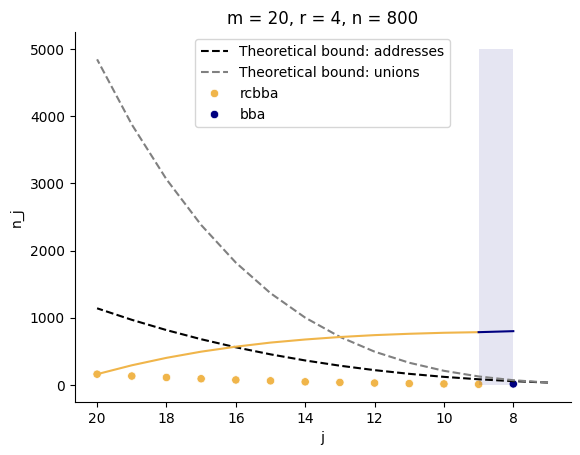

In [16]:
sn.lineplot(data, y = '# of addresses', x = 'm', label = 'Theoretical bound: addresses', color = 'black', linestyle = '--')
sn.lineplot(data, y = '# of unions', x = 'm', label = 'Theoretical bound: unions', color = 'gray', linestyle = '--')
sn.scatterplot(ns, x = 'j', y = 'nj', hue = 'alg', palette = [bba_color, rcbba_color])
sn.lineplot(ns.head(len(ns)-1), x = 'j', y = 'n', color = bba_color)
sn.lineplot(ns.tail(2), x = 'j', y = 'n', color = rcbba_color)

ax = plt.gca()
rect = mpatches.Rectangle((8, 0), 1, 5000, linewidth=0, facecolor=rcbba_color, alpha=0.1)
ax.add_patch(rect)


plt.gca().invert_xaxis()
plt.xlabel('j')
plt.ylabel('n_j')
plt.title('m = 20, r = 4, n = 800')
plt.legend()
sn.despine()